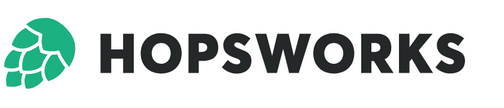

# Derived Features Pipeline with Aggregations

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/featurestoreorg/serverless-ml-course/blob/main/nbs/01-module/1a_feature_groups.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

## 🗒️ This notebook is divided in 2 sections:
1. Reading the synthetic credit card data and feature engineeing,
2. Write the Pandas DataFrames to the feature groups in the feature store.


In [ ]:
!pip install -U hopsworks --quiet

In [1]:
!cd .. & pip install -e ../.

Obtaining file:///home/david/learnings/serveless/serverless-ml-course/src/06-module
  Attempting uninstall: sml
    Found existing installation: sml 0.1
    Uninstalling sml-0.1:
      Successfully uninstalled sml-0.1
  Running setup.py develop for sml


In [2]:
import pandas as pd
import datetime
import hopsworks

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/79010
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Run this program every X hours. It will compute credit usage statistics every X hours.

In [4]:
import numpy as np
from sml.features import cc_features
import datetime

trans_fg = fs.get_feature_group(name="transactions_fraud_online", version=1)

DATE_FORMAT = '%Y-%m-%d %H:%M:%S'

# TODO (davit): save event time feature as datetime and and this will not be necessary
START_DATE = (datetime.datetime.now() - datetime.timedelta(hours=8))#.strftime(DATE_FORMAT) 
trans_df = trans_fg.filter(trans_fg.datetime > int(START_DATE.timestamp() *1000)).read()
trans_df.datetime =  trans_df.datetime.map(lambda x: datetime.datetime.fromtimestamp(x//1000)) 
trans_df

2023-07-25 23:43:01,618 INFO: USE `dev_mlops_featurestore`
2023-07-25 23:43:01,930 INFO: SELECT `fg0`.`month` `month`, `fg0`.`tid` `tid`, `fg0`.`datetime` `datetime`, `fg0`.`cc_num` `cc_num`, `fg0`.`category` `category`, `fg0`.`amount` `amount`, `fg0`.`city` `city`, `fg0`.`country` `country`, `fg0`.`age_at_transaction` `age_at_transaction`, `fg0`.`days_until_card_expires` `days_until_card_expires`, `fg0`.`loc_delta_t_minus_1` `loc_delta_t_minus_1`, `fg0`.`time_delta_t_minus_1` `time_delta_t_minus_1`
FROM `dev_mlops_featurestore`.`transactions_fraud_online_1` `fg0`
WHERE `fg0`.`datetime` > 1690314181233


,month,tid,datetime,cc_num,category,amount,city,country,age_at_transaction,days_until_card_expires,loc_delta_t_minus_1,time_delta_t_minus_1
0,2023-07,925da3d6146b7efbc2acf02bd9bb030c,2023-07-25 15:59:19,4797751386008277,Grocery,23.15,Riverbank,US,43.751296,798.167141,0.008884,19.555741
1,2023-07,37f4d77fbcfa2e4aa100cb347b0c5e0c,2023-07-25 18:32:00,4588380985224268,Restaurant/Cafeteria,52.08,Huntley,US,20.687458,372.061111,0.002000,4.457604
2,2023-07,c621eecab64c814a2199443bde30c6b4,2023-07-25 18:06:25,4897369589533543,Domestic Transport,99.62,Bryn Mawr-Skyway,US,36.241459,403.078877,0.013630,5.805509
3,2023-07,f591097f01708f8a786261e9df77f71e,2023-07-25 19:02:59,4054298322046472,Grocery,73.31,Port Huron,US,20.441105,1559.039595,0.002643,0.479005
4,2023-07,195ecd96c0a1c7aba28b72e05b765af4,2023-07-25 16:00:49,4929411498746287,Grocery,98.12,Woodlawn,US,83.196325,1680.166100,0.000956,0.395914
...,...,...,...,...,...,...,...,...,...,...,...,...
1739,2023-07,7b48038884fbe311fbb603d67e1a7bc2,2023-07-25 16:25:33,4031729349852409,Clothing,92.89,Kahului,US,18.474989,250.148924,0.012814,0.011146
1740,2023-07,c35f0885000e48afe58beb7121d5c5ab,2023-07-25 17:47:29,4698372389832702,Domestic Transport,44.77,Port Richmond,US,87.527897,1406.092025,0.014814,0.037303
1741,2023-07,84bfc3a48eabd0cbbc0596a68aab3586,2023-07-25 18:20:11,4615247828260725,Grocery,87.64,Murray,US,99.287270,1528.069317,0.002548,0.002674
1742,2023-07,0b7b530b2bf294aac34190c211ab3c7d,2023-07-25 18:26:30,4484286741644605,Grocery,34.47,New City,US,83.985120,1711.064931,0.005733,0.008553


In [5]:
window_len = 4
window_aggs_df = cc_features.aggregate_activity_by_hour(trans_df, window_len)
window_aggs_df = window_aggs_df.dropna()
window_aggs_df.datetime = window_aggs_df.datetime.map(lambda x: int(x.timestamp() * 1000)) 

window_aggs_df

,trans_volume_mstd,trans_volume_mavg,trans_freq,loc_delta_mavg,cc_num,datetime,month
103,39.961963,53.4750,0.006305,0.009922,4494402666200582,1690300117000,2023-07
114,10.113771,36.7650,0.006441,0.003408,4764722168656608,1690311631000,2023-07
128,31.525737,36.2250,0.568880,0.005689,4705647145380059,1690302604000,2023-07
146,8.514542,35.0225,0.007384,0.003391,4764722168656608,1690305305000,2023-07
148,46.795208,30.3300,0.018186,0.013393,4837818088536715,1690301025000,2023-07
...,...,...,...,...,...,...,...
1739,43.683624,70.2850,0.005862,0.006052,4031729349852409,1690302333000,2023-07
1740,14.384106,50.9625,0.015093,0.009864,4698372389832702,1690307249000,2023-07
1741,406.268180,264.8750,0.006305,0.004755,4615247828260725,1690309211000,2023-07
1742,375.368391,218.6575,0.015391,0.003928,4484286741644605,1690309590000,2023-07


You can move on and do the same thing for the feature group with our windows aggregation.

In [6]:
window_aggs_fg = fs.get_feature_group(name=f"cc_trans_fraud_{window_len}h", version=2)
window_aggs_fg.insert(window_aggs_df, write_options={"wait_for_job" : False})

Uploading Dataframe: 0.00% |          | Rows 0/1398 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: cc_trans_fraud_4h_2_offline_fg_backfill
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/79010/jobs/named/cc_trans_fraud_4h_2_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7f32a639c9a0>, None)

Both feature groups are now accessible and searchable in the UI

### We have to deal with missing data

Not all credit cards are used within the time window.
The hsfs client may return "missing" if the primary key for a credit_card is not in window_aggs_fg.